## Get all the imports

In [ ]:
import pandas as pd
import numpy as np
import torch
torch.manual_seed(27)
import random
random.seed(27)
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## A utility function for counting the number of trainable parameters in a model

In [ ]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Define the text pre-processing pipeline

In [ ]:
# Pre-process text by removing stopwords, punctuations, adding special tokens
# and setting all samples to the same length for efficient batching of data
def text_preprocess_pipeline(text_list, max_len=32):
    # Get the stopwords
    stop_words = set(stopwords.words('english'))
    text_list_processed = list()
    for text in tqdm(text_list, desc="Pre-processing Data"):
        # Convert to lowercase and remove leading and trailing spaces
        text = text.lower().strip()
        # Tokenize the text
        tokens = word_tokenize(text)
        # Remove stopwords and punctuations
        cleaned_tokens = [token for token in tokens if (token not in stop_words and token.isalpha())]
        # Chop text size to max length
        cleaned_tokens = cleaned_tokens[:max_len-1]
        # Append special token to denote end of sentence
        cleaned_tokens.append("<eos>")
        # Append <pad> token if required to achieve fixed length for each sample
        if len(cleaned_tokens) < max_len:
            cleaned_tokens+= ["<pad>" for i in range(max_len-len(cleaned_tokens))]
        # Finally save the cleaned text
        text_list_processed.append(cleaned_tokens)
    return text_list_processed

## Define a function to generate a vocabulary and convert tokens to ids

In [ ]:
# Generate vocabulary and convert text to ids
def convert_text_to_idx(text_list_tokenized, create_vocab=True, token_to_idx=None):
    # This will save all the ids corresponding to each token
    if create_vocab:
        token_to_idx = {"<pad>": 0, "<eos>": 1, "<unk>": 2}
        # This will save all tokens corresponding to each id
        idx_to_token = dict([[value, key] for key, value in token_to_idx.items()])
        # This counter determines the id for each token
        idx_counter = 3
    # This will save the frequency of each token
    token_freq = dict([[key, 0] for key in token_to_idx.keys()])
    # All tokenized sentences converted to ids will be saved here
    text_list_converted = list()

    # Generate the vocab and convert to ids
    for text_tokenized in tqdm(text_list_tokenized, desc="Generating vocab and converting to ids"):
        tokens_as_ids = list()
        for token in text_tokenized:
            if token not in token_to_idx:
                # If token does not exist in vocab and we have to generate the vocab
                # Then add it to the vocab and assign a unique id
                if create_vocab:
                    token_to_idx[token] = idx_counter
                    idx_to_token[idx_counter] = token
                    token_freq[token] = 1
                    idx_counter+=1
                # If token does not exist in vocab and we are not creating the vocab
                # Then assign the special token <unk>
                else:
                    token = "<unk>"
                    token_freq[token]+=1
            # If token exists in vocab then increase its frequency
            else:
                token_freq[token]+=1
            tokens_as_ids.append(token_to_idx[token])
        text_list_converted.append(tokens_as_ids)
    # Return the list and all three dictionaries
    if create_vocab:
        return text_list_converted, token_to_idx, idx_to_token, token_freq
    else:
        return text_list_converted, token_freq

## Define a function to perform one-hot-encoding of the target

In [ ]:
# Convert target to OHE
def ohe(target, ohe_size):
    target_ohe = np.zeros((len(target), ohe_size))
    for idx, val in enumerate(target):
        target_ohe[idx,val] = 1
    return target_ohe

## Load the data, pre-process and split into train and validation

In [ ]:
seq_len = 16

# Load the train set
df_train = pd.read_csv("train.csv")
# Pre-process the data
X = text_preprocess_pipeline(df_train["text"], seq_len)
# Convert target to OHE
Y = ohe(df_train["label-coarse"], df_train["label-coarse"].max()+1)
# Now Split the data into train and val
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=27, stratify=df_train["label-coarse"].values)
print("\nThe first tokenized sentence in the train set\n", X_train[0], "\n The total number of samples in train set", len(X_train))
print("\nThe first tokenized sentence in the validation set\n", X_val[0], "\n The total number of samples in validation set", len(X_val), "\n\n")
# Convert text to ids
X_train, token_to_idx, idx_to_token, token_freq_train = convert_text_to_idx(X_train, create_vocab=True, token_to_idx=None)
X_val, token_freq_val = convert_text_to_idx(X_val, create_vocab=False, token_to_idx=token_to_idx)
print("\nThe first id based sentence in the train set\n", X_train[0])
print("\nThe first id based sentence in the validation set\n", X_val[0], "\n\n")
# Check out the top 10 tokens in each set
token_freq_train = Counter(token_freq_train)
print("\n\n\nTop 10 most frequent tokens in the Train set:\n", token_freq_train.most_common(10))
token_freq_val = Counter(token_freq_val)
print("\n\nTop 10 most frequent tokens in the Validation set:\n", token_freq_val.most_common(10))

Pre-processing Data: 100%|██████████| 5452/5452 [00:00<00:00, 32254.55it/s]



The first tokenized sentence in the train set
 ['<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
 The total number of samples in train set 4361

The first tokenized sentence in the validation set
 ['british', 'female', 'pop', 'singing', 'star', 'early', 'child', 'actress', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
 The total number of samples in validation set 1091 




Generating vocab and converting to ids: 100%|██████████| 1091/1091 [00:00<00:00, 538731.54it/s]


The first id based sentence in the train set
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

The first id based sentence in the validation set
 [667, 1528, 3507, 2125, 1515, 2858, 316, 272, 1, 0, 0, 0, 0, 0, 0, 0] 





Top 10 most frequent tokens in the Train set:
 [('<pad>', 46086), ('<eos>', 4361), ('many', 277), ('name', 265), ('first', 153), ('world', 140), ('country', 107), ('city', 99), ('people', 78), ('called', 71)]


Top 10 most frequent tokens in the Validation set:
 [('<pad>', 11576), ('<eos>', 1091), ('<unk>', 1066), ('name', 66), ('many', 55), ('first', 46), ('country', 26), ('world', 25), ('city', 21), ('long', 20)]


## Load the test data and pre-process

In [ ]:
# Load the test set
df_test = pd.read_csv("test.csv")
# Pre-process the data
X_test = text_preprocess_pipeline(df_test["text"], seq_len)
# Convert target to OHE
Y_test = ohe(df_test["label-coarse"], df_test["label-coarse"].max()+1)
print("\nThe first tokenized sentence in the test set\n", X_test[0], "\n The total number of samples in test set", len(X_test), "\n")
# Convert text to ids
X_test, token_freq_test = convert_text_to_idx(X_test, create_vocab=False, token_to_idx=token_to_idx)
print("\nThe first id based sentence in the test set\n", X_test[0])
# Check out the most common words
token_freq_test = Counter(token_freq_test)
print("\n\nTop 10 most frequent tokens in the Test set:\n", token_freq_test.most_common(10))

Pre-processing Data: 100%|██████████| 500/500 [00:00<00:00, 40438.72it/s]



The first tokenized sentence in the test set
 ['far', 'denver', 'aspen', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
 The total number of samples in test set 500 



Generating vocab and converting to ids: 100%|██████████| 500/500 [00:00<00:00, 605588.22it/s]


The first id based sentence in the test set
 [1348, 6741, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Top 10 most frequent tokens in the Test set:
 [('<pad>', 6031), ('<eos>', 500), ('<unk>', 328), ('first', 23), ('name', 17), ('state', 17), ('year', 16), ('president', 14), ('called', 12), ('city', 10)]


## Visualizing the class distribution

Text(0, 0.5, 'Frequency')

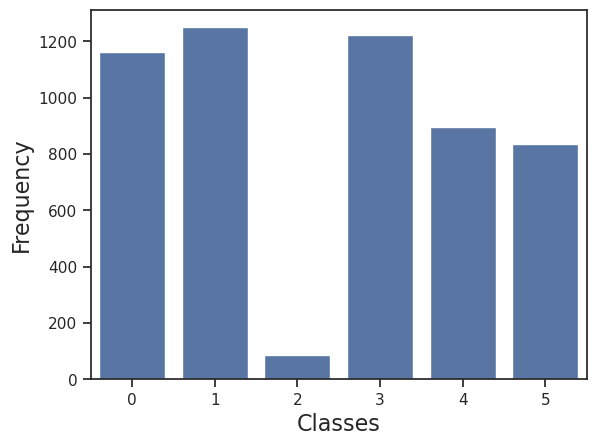

In [ ]:
class_counts = [df_train[df_train["label-coarse"] == class_index].count()["label-coarse"] for class_index in range(df_train["label-coarse"].max()+1)]
sns.barplot(x=np.arange(len(Y[0])), y=class_counts)
plt.xlabel("Classes", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

## Word cloud to visualize token frequency in the train set

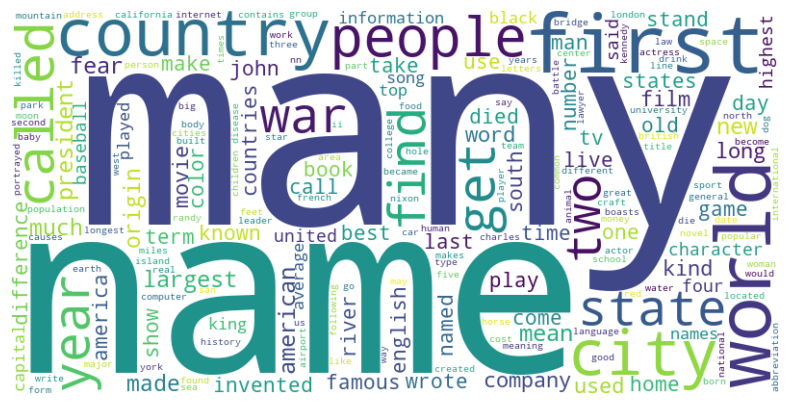

In [ ]:
tmp_token_freq_train = deepcopy(token_freq_train)
tmp_token_freq_train.pop("<pad>")
tmp_token_freq_train.pop("<eos>")
tmp_token_freq_train.pop("<unk>")
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tmp_token_freq_train)
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.show()

## Word cloud to visualize token frequency in the validation set

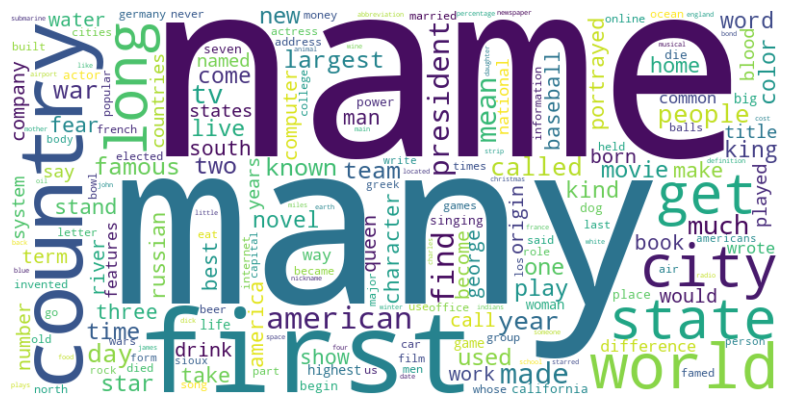

In [ ]:
tmp_token_freq_val = deepcopy(token_freq_val)
tmp_token_freq_val.pop("<pad>")
tmp_token_freq_val.pop("<eos>")
tmp_token_freq_val.pop("<unk>")
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tmp_token_freq_val)
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.show()

## Word cloud to visualize token frequency in the test set

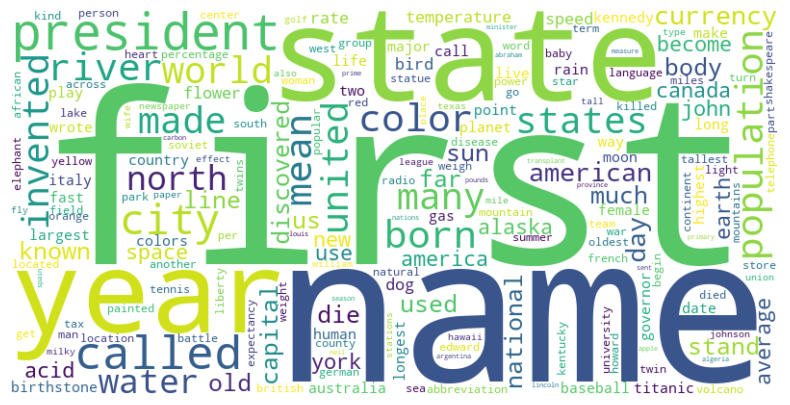

In [ ]:
tmp_token_freq_test = deepcopy(token_freq_test)
tmp_token_freq_test.pop("<pad>")
tmp_token_freq_test.pop("<eos>")
tmp_token_freq_test.pop("<unk>")
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tmp_token_freq_test)
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.show()

## Word Cloud per class in the train set

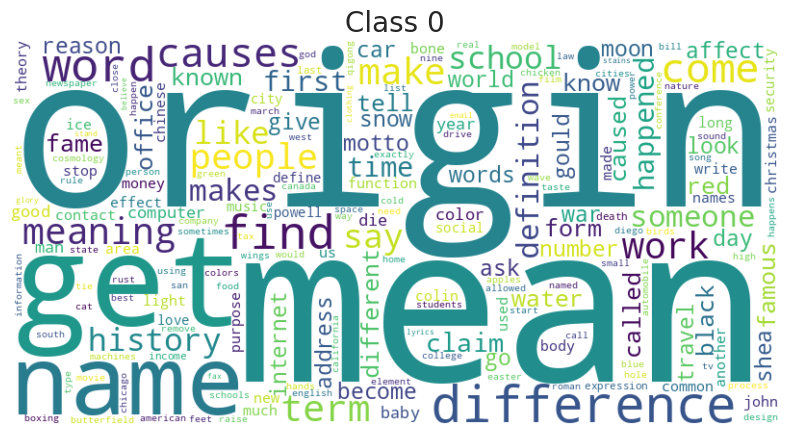

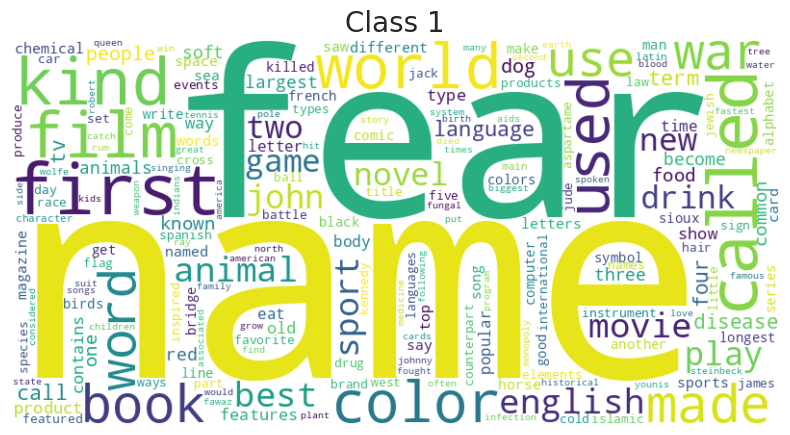

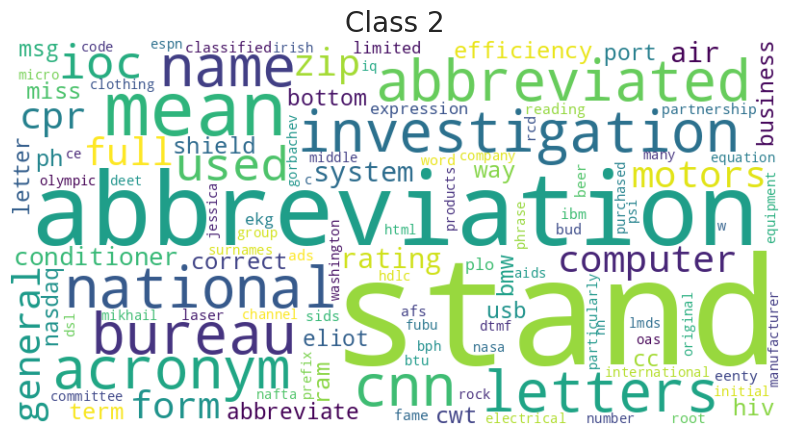

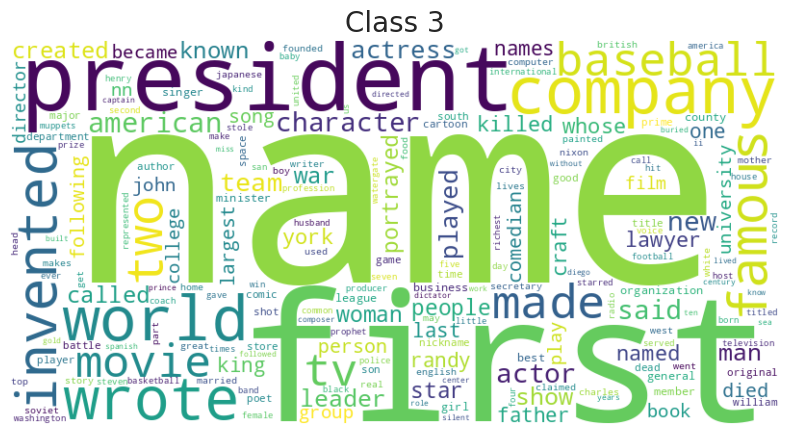

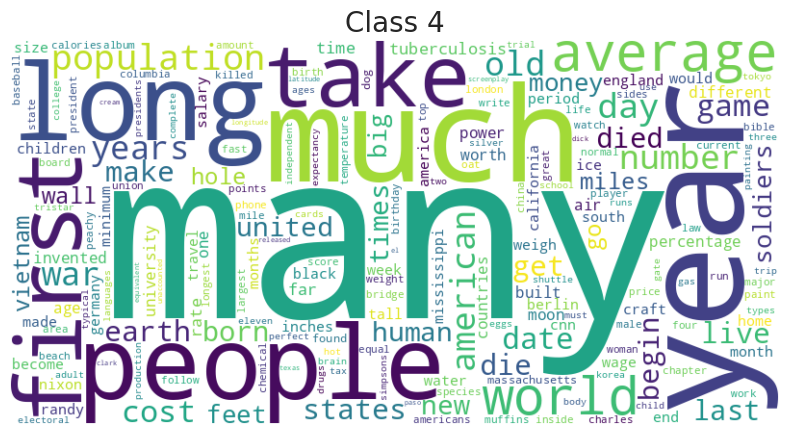

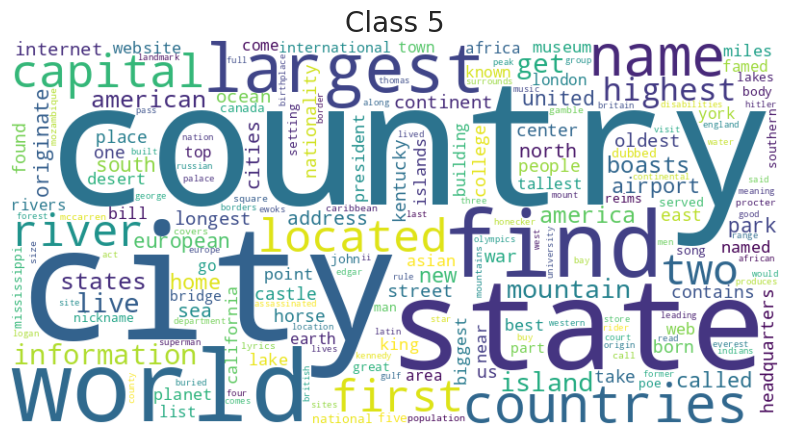

In [ ]:
for class_index in range(df_train["label-coarse"].max()+1):
    indices = np.where(Y_train[:,class_index]==1)[0]
    total_tokens = list()
    for index in indices:
        tokens = [idx_to_token[idx] for idx in X_train[index]]
        total_tokens.extend(tokens)
    total_tokens = Counter(total_tokens)
    total_tokens.pop("<pad>")
    total_tokens.pop("<eos>")
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(total_tokens)
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide axes
    plt.title("Class "+str(class_index), fontsize=20)
    plt.show()
    plt.close()
    print("\n\n")

## Define the embedding and positional encoding layers

In [ ]:
class EmbeddingLayer(torch.nn.Module):
    def __init__(self, d_model, vocab_size):
        super(EmbeddingLayer, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embedding(x) * np.sqrt(self.d_model)


class PositionalEncodingLayer(torch.nn.Module):
    def __init__(self, d_model, seq_len, dropout):
        super(PositionalEncodingLayer, self).__init__()
        # Add dropout if required
        self.dropout = torch.nn.Dropout(p=dropout)
        # Create an embedding of seq_len x d_model.
        # This will be applied across batches
        pe = torch.zeros(seq_len, d_model)
        # Define the numerator
        position = torch.arange(0, seq_len).unsqueeze(1)
        # Define the denominator
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.math.log(10000.0) / d_model))
        # start_pos:en_pos:skip = 0::2
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # Do not register pe as a parameter hence no grad calculations
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)

## What does the positional embedding output look like?

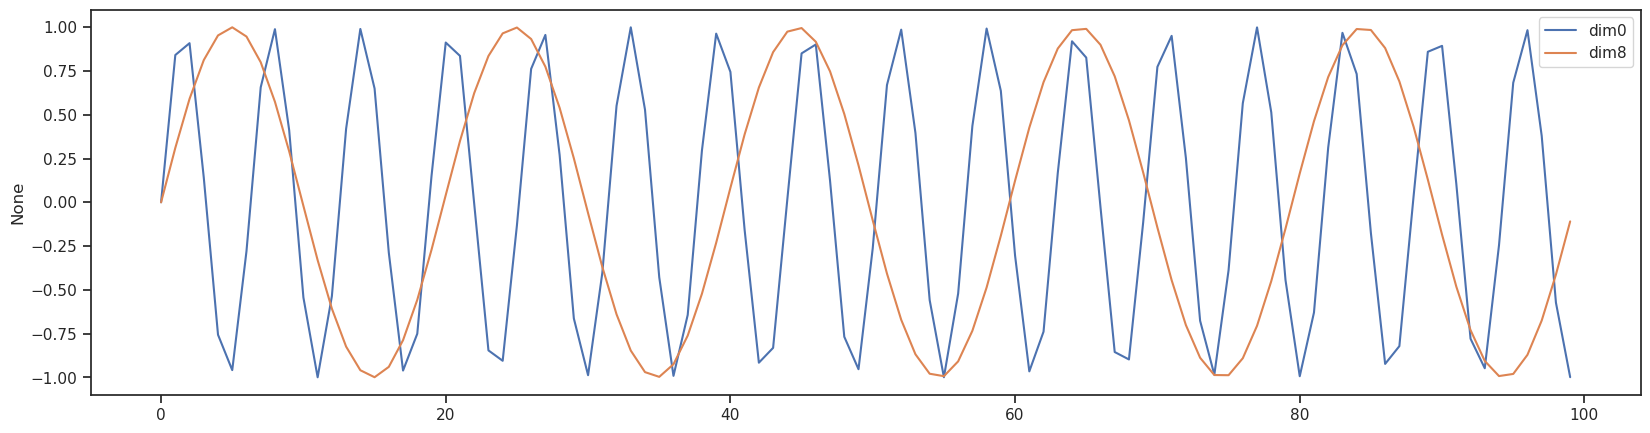

In [ ]:
# Create the positional embedding layer
pe = PositionalEncodingLayer(64, 100, 0)
# Perform a forward pass on dummy data
dummy_output = pe.forward(torch.zeros(1, 100, 64)).squeeze()
plt.figure(figsize=(20, 5))
# Plot the output
for i in range(0, 16, 8):
    sns.lineplot(x=np.arange(100), y=dummy_output[:,i], label="dim"+str(i))
plt.show()

## Define the multi-head attention layer
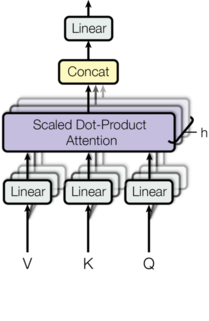

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super(MultiHeadAttention, self).__init__()
        # Make sure that the embedding dimension is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.dropout = dropout
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        # Define the attention projection layers
        self.W_q = torch.nn.Linear(d_model, d_model)
        self.W_k = torch.nn.Linear(d_model, d_model)
        self.W_v = torch.nn.Linear(d_model, d_model)
        self.W_o = torch.nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Perform scaled attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        print(Q.shape, K.transpose(-2, -1).shape, attn_scores.shape)
        if mask is not None:
            # Wherever the mask is 0, replace the values with -1e9
            # This ensures that e^(-1e9)=0 when computing softmax
            mask = mask.view(mask.shape[0], 1, 1, mask.shape[1])
            attn_scores = attn_scores.masked_fill(mask != 0, -1e9)
        # Compute softmax to generate the attention scores
        attn_probs = torch.softmax(attn_scores, dim=-1)
        # Multiply the attention scores back Value
        output = torch.matmul(attn_probs, V)
        return output, attn_probs

    # This function splits the output into different heads
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        # The view function performs efficient reshaping without making a copy
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    # This function combines the output from each attention head
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        # performing transpose leads to different slices of the same tensor
        # to be in different memory locations. For efficient reshapeing with view,
        # the tensor must exist in the same memory location.
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Perform a forward pass through the linear layer
        # Then split into heads to compute attention scores separately
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        # Apply self-attention
        attn_output, attn_wts = self.scaled_dot_product_attention(Q, K, V, mask)
        # Final projection
        output = self.W_o(self.combine_heads(attn_output))
        return output, attn_wts

In [ ]:
mh = MultiHeadAttention(512, 8, 0)
dummy_data = torch.zeros((32, 100, 512))
mh.forward(dummy_data, dummy_data, dummy_data)
print()

torch.Size([32, 8, 100, 64]) torch.Size([32, 8, 64, 100]) torch.Size([32, 8, 100, 100])



## Define the Positionwise feed-forward Networks

In [ ]:
class PositionWiseFeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(d_model, d_ff)
        self.fc2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.dropout(torch.nn.ReLU()((self.fc1(x)))))

## Define the Encoder block
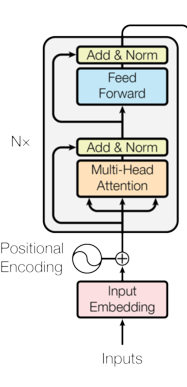

In [ ]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, mask):
        # Get output from multi-head attention layer
        attn_output, _ = self.self_attn(x, x, x, mask)
        # Add skip connection and then normalize
        x = self.norm1(x + self.dropout(attn_output))
        # Get output from projection layers
        ff_output = self.feed_forward(x)
        # Add skip connection and then normalize
        x = self.norm2(x + self.dropout(ff_output))
        return x

## Define the decoder block
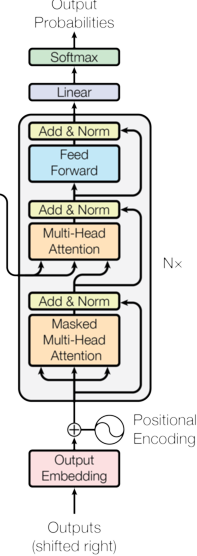

In [ ]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Generate the self-attention output
        attn_output, _ = self.self_attn(x, x, x, tgt_mask)
        # Apply skip conenction and then normalize
        x = self.norm1(x + self.dropout(attn_output))
        # Now use cross-attention. The query is from current decoder
        attn_output, _ = self.cross_attn(x, enc_output, enc_output, src_mask)
        # Apply skip conenction and then normalize
        x = self.norm2(x + self.dropout(attn_output))
        # Get output from projection layers
        ff_output = self.feed_forward(x)
        # Apply skip conenction and then normalize
        x = self.norm3(x + self.dropout(ff_output))
        return x

## Finally, define the transformer model

In [ ]:
class Transformer(torch.nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_enc_layers, num_dec_layers, d_ff, seq_len, dropout, num_classes):
        super(Transformer, self).__init__()
        # The encoder and decoder embeddings are going to be shared since this is not a translation task
        self.encoder_embedding = self.decoder_embedding = EmbeddingLayer(d_model, vocab_size)
        self.positional_encoding = PositionalEncodingLayer(d_model, seq_len, dropout)
        # Stack encoder and decoder blocks
        self.encoder_layers = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_enc_layers)])
        self.decoder_layers = torch.nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_dec_layers)])
        # Final classification layer
        self.fc = torch.nn.Linear(d_model, num_classes)
        self.dropout = torch.nn.Dropout(dropout)
        # Define the optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        # Define the objective function
        self.criterion = torch.nn.CrossEntropyLoss()
        # self.apply(self.weights_init)

    # def weights_init(self, m):
    #     if isinstance(m, torch.nn.Linear):
    #         torch.nn.init.xavier_uniform_(m.weight)
    #         torch.nn.init.constant_(m.bias, 0)

    # Generate masks to make sure that our model does not attend to <pad> tokens
    def generate_mask(self, src, tgt):
        src_mask = (src == 0)
        tgt_mask = (tgt == 0)
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        # Generate masks for the given sequence
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        # Get the embeddings
        src_embedded = self.positional_encoding(self.encoder_embedding(src))
        tgt_embedded = self.positional_encoding(self.decoder_embedding(tgt))
        # Get output from the final encoder block
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
        # Get output from the final decoder layer
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
        # Aggregate the final decoder layer output
        output = torch.max(dec_output, dim=1).values
        # Perform classification
        output = self.fc(output)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        self.optimizer.zero_grad()
        preds = self.forward(x, x)
        loss = self.criterion(preds, y)
        loss.backward()
        self.optimizer.step()
        return loss.item(), preds.numpy(force=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x, x)
        loss = self.criterion(preds, y)
        return loss.item(), preds.numpy(force=True)

## Create the data loaders

In [ ]:
batch_size = 128
num_workers = 32

train_data_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(Y_train)), batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_data_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(Y_val)), batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_data_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(Y_test)), batch_size=batch_size, num_workers=num_workers, shuffle=False)

## Some hyperparameters

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 100
num_classes = df_train["label-coarse"].max()+1
vocab_size = len(token_to_idx)
d_model = 64
num_heads = 2
num_enc_layers = 4
num_dec_layers = 4
d_ff = 128
dropout = 0.6

## Perform training and validation using our custom transformer implementation

In [ ]:
model = Transformer(vocab_size, d_model, num_heads, num_enc_layers, num_dec_layers, d_ff, seq_len, dropout, num_classes)
print("\nTrainable Parameters:", count_trainable_parameters(model)/1000000, "M\n\n")
model.to(device)

train_epoch_loss = list()
val_epoch_loss = list()
min_val_loss = np.inf
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    # Training loop
    train_iter_loss = list()
    model.train()
    for batch_idx, batch in enumerate(train_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.training_step(batch, batch_idx)
        train_iter_loss.append(loss)
    train_epoch_loss.append(sum(train_iter_loss)/len(train_iter_loss))

    # Validation loop
    val_iter_loss = list()
    model.eval()
    for batch_idx, batch in enumerate(val_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.validation_step(batch, batch_idx)
        val_iter_loss.append(loss)
    val_epoch_loss.append(sum(val_iter_loss)/len(val_iter_loss))
    if val_epoch_loss[-1] < min_val_loss:
        min_val_loss = val_epoch_loss[-1]
        best_model = deepcopy(model)
    pbar.set_description("train_loss: "+str(train_epoch_loss[-1])+"\tval_loss:"+str(val_epoch_loss[-1]))


Trainable Parameters: 0.77511 M




train_loss: 0.7340952822063483	val_loss:1.1909453750289094: 100%|██████████| 100/100 [04:59<00:00,  2.99s/it]


## Plot the training and validation losses

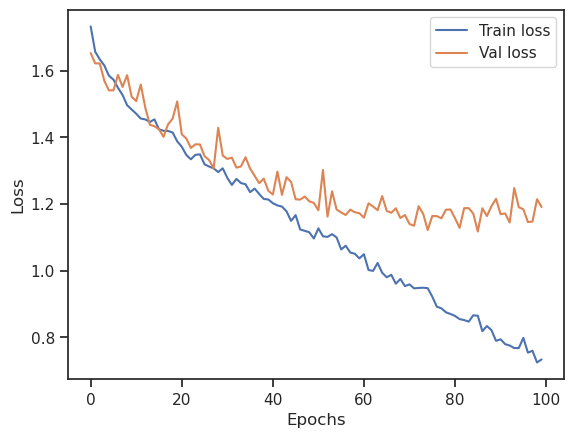

In [ ]:
sns.lineplot(x=np.arange(num_epochs), y=train_epoch_loss, label="Train loss")
sns.lineplot(x=np.arange(num_epochs), y=val_epoch_loss, label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Get all the predictions on the train and validation set

In [ ]:
train_data_loader_copy = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(Y_train)), batch_size=batch_size, num_workers=num_workers, shuffle=False)
train_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(train_data_loader_copy), total=len(train_data_loader_copy), desc="Predicting on Train set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    train_total_predictions.extend(preds)
train_total_predictions = np.argmax(np.asarray(train_total_predictions), axis=1)
ground_truth = np.argmax(Y_train, axis=1)
print("\nTrain Accuracy:", accuracy_score(train_total_predictions, ground_truth))
print("Train Precision:", precision_score(train_total_predictions, ground_truth, average="micro"))
print("Train Confusion Matrix:\n", confusion_matrix(train_total_predictions, ground_truth), "\n\n")

val_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(val_data_loader), total=len(val_data_loader), desc="Predicting on Val set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    val_total_predictions.extend(preds)
val_total_predictions = np.argmax(np.asarray(val_total_predictions), axis=1)
ground_truth = np.argmax(Y_val, axis=1)
print("\nValidation Accuracy:", accuracy_score(val_total_predictions, ground_truth))
print("Validation Precision:", precision_score(val_total_predictions, ground_truth, average="micro"))
print("Validation Confusion Matrix:\n", confusion_matrix(val_total_predictions, ground_truth), "\n\n")

test_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(test_data_loader), total=len(test_data_loader), desc="Predicting on Test set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    test_total_predictions.extend(preds)
test_total_predictions = np.argmax(np.asarray(test_total_predictions), axis=1)
ground_truth = np.argmax(Y_test, axis=1)
print("\nTest Accuracy:", accuracy_score(test_total_predictions, ground_truth))
print("Test Precision:", precision_score(test_total_predictions, ground_truth, average="micro"))
print("Test Confusion Matrix:\n", confusion_matrix(test_total_predictions, ground_truth), "\n\n")


Predicting on Train set: 100%|██████████| 35/35 [00:00<00:00, 114.92it/s]


Train Accuracy: 0.8376519146984637
Train Precision: 0.8376519146984637
Train Confusion Matrix:
 [[723  22  21  11  17  30]
 [ 89 859   2  96  13  15]
 [  6   0  46   0   0   1]
 [ 28  77   0 821  47  26]
 [ 26  11   0  10 617   9]
 [ 57  31   0  40  23 587]] 





Predicting on Val set: 100%|██████████| 9/9 [00:00<00:00, 54.85it/s]


Validation Accuracy: 0.6278643446379468
Validation Precision: 0.6278643446379468
Validation Confusion Matrix:
 [[145  46   6  30  10  24]
 [ 24 111   0  19   7   8]
 [  2   0  11   0   0   0]
 [ 35  71   0 176  23  19]
 [  7   5   0   8 128   2]
 [ 20  17   0  12  11 114]] 





Predicting on Test set: 100%|██████████| 4/4 [00:00<00:00, 34.12it/s]


Test Accuracy: 0.664
Test Precision: 0.664
Test Confusion Matrix:
 [[122  16   2   7  16  13]
 [  9  36   0   4   7   2]
 [  0   0   7   0   0   0]
 [  4  26   0  44  19   5]
 [  1   0   0   1  65   3]
 [  2  16   0   9   6  58]] 




## Replace custom Multi Head Attention Layer with PyTorch Multi Head Attention and perform training and validation

In [ ]:
model = Transformer(vocab_size, d_model, num_heads, num_enc_layers, num_dec_layers, d_ff, seq_len, dropout, num_classes)
# Replace the multi-head attention layers with Pytorch version
for i in range(num_enc_layers):
    model.encoder_layers[i].self_attn = torch.nn.MultiheadAttention(d_model, num_heads, dropout, batch_first=True)
for i in range(num_dec_layers):
    model.decoder_layers[i].self_attn = torch.nn.MultiheadAttention(d_model, num_heads, dropout, batch_first=True)
    model.decoder_layers[i].cross_attn = torch.nn.MultiheadAttention(d_model, num_heads, dropout, batch_first=True)
print("\nTrainable Parameters:", count_trainable_parameters(model)/1000000, "M\n\n")
model.to(device)

train_epoch_loss = list()
val_epoch_loss = list()
min_val_loss = np.inf
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    # Training loop
    train_iter_loss = list()
    model.train()
    for batch_idx, batch in enumerate(train_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.training_step(batch, batch_idx)
        train_iter_loss.append(loss)
    train_epoch_loss.append(sum(train_iter_loss)/len(train_iter_loss))

    # Validation loop
    val_iter_loss = list()
    model.eval()
    for batch_idx, batch in enumerate(val_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.validation_step(batch, batch_idx)
        val_iter_loss.append(loss)
    val_epoch_loss.append(sum(val_iter_loss)/len(val_iter_loss))
    if val_epoch_loss[-1] < min_val_loss:
        min_val_loss = val_epoch_loss[-1]
        best_model = deepcopy(model)
    pbar.set_description("train_loss: "+str(train_epoch_loss[-1])+"\tval_loss:"+str(val_epoch_loss[-1]))


Trainable Parameters: 0.77511 M




train_loss: 1.4641987273669599	val_loss:2.2230886645786394: 100%|██████████| 100/100 [04:51<00:00,  2.92s/it]


## Plot the training and validation losses

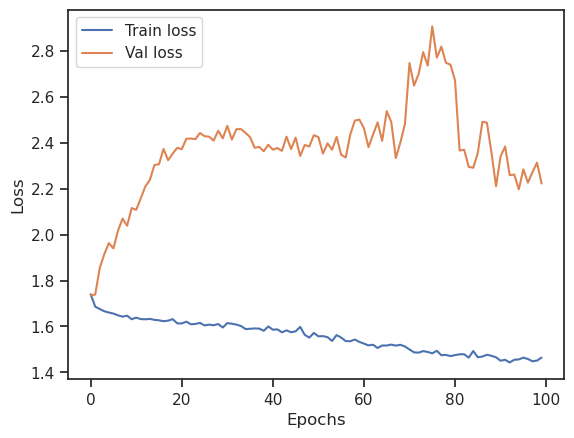

In [ ]:
sns.lineplot(x=np.arange(num_epochs), y=train_epoch_loss, label="Train loss")
sns.lineplot(x=np.arange(num_epochs), y=val_epoch_loss, label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Get all the predictions on the train and validation set

In [ ]:
train_data_loader_copy = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(Y_train)), batch_size=batch_size, num_workers=num_workers, shuffle=False)
train_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(train_data_loader_copy), total=len(train_data_loader_copy), desc="Predicting on Train set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    train_total_predictions.extend(preds)
train_total_predictions = np.argmax(np.asarray(train_total_predictions), axis=1)
ground_truth = np.argmax(Y_train, axis=1)
print("\nTrain Accuracy:", accuracy_score(train_total_predictions, ground_truth))
print("Train Precision:", precision_score(train_total_predictions, ground_truth, average="micro"))
print("Train Confusion Matrix:\n", confusion_matrix(train_total_predictions, ground_truth), "\n\n")

val_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(val_data_loader), total=len(val_data_loader), desc="Predicting on Val set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    val_total_predictions.extend(preds)
val_total_predictions = np.argmax(np.asarray(val_total_predictions), axis=1)
ground_truth = np.argmax(Y_val, axis=1)
print("\nValidation Accuracy:", accuracy_score(val_total_predictions, ground_truth))
print("Validation Precision:", precision_score(val_total_predictions, ground_truth, average="micro"))
print("Validation Confusion Matrix:\n", confusion_matrix(val_total_predictions, ground_truth), "\n\n")

test_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(test_data_loader), total=len(test_data_loader), desc="Predicting on Test set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    test_total_predictions.extend(preds)
test_total_predictions = np.argmax(np.asarray(test_total_predictions), axis=1)
ground_truth = np.argmax(Y_test, axis=1)
print("\nTest Accuracy:", accuracy_score(test_total_predictions, ground_truth))
print("Test Precision:", precision_score(test_total_predictions, ground_truth, average="micro"))
print("Test Confusion Matrix:\n", confusion_matrix(test_total_predictions, ground_truth), "\n\n")


Predicting on Train set: 100%|██████████| 35/35 [00:00<00:00, 116.21it/s]



Train Accuracy: 0.2462737904150424
Train Precision: 0.2462737904150424
Train Confusion Matrix:
 [[202 151   9 154 125  92]
 [237 218  14 183 127 116]
 [  0   0   0   0   0   0]
 [473 606  43 630 441 446]
 [ 17  25   3  11  24  14]
 [  0   0   0   0   0   0]] 




Predicting on Val set: 100%|██████████| 9/9 [00:00<00:00, 56.36it/s]


Validation Accuracy: 0.25939505041246563
Validation Precision: 0.25939505041246563
Validation Confusion Matrix:
 [[ 73  41   5  53  47  24]
 [ 60  63   7  47  30  30]
 [  0   0   0   0   0   0]
 [ 90 139   5 140  95 108]
 [ 10   7   0   5   7   5]
 [  0   0   0   0   0   0]] 





Predicting on Test set: 100%|██████████| 4/4 [00:00<00:00, 29.99it/s]


Test Accuracy: 0.132
Test Precision: 0.132
Test Confusion Matrix:
 [[ 14  11   2  11  27  11]
 [104  20   3  24  29  11]
 [  0   0   0   0   0   0]
 [ 18  59   4  27  52  59]
 [  2   4   0   3   5   0]
 [  0   0   0   0   0   0]] 




## Define the Pytorch Transformer model

In [ ]:
class Transformer(torch.nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_enc_layers, num_dec_layers, d_ff, seq_len, dropout, num_classes):
        super(Transformer, self).__init__()
        # The encoder and decoder embeddings are going to be shared since this is not a translation task
        self.encoder_embedding = self.decoder_embedding = EmbeddingLayer(d_model, vocab_size)
        self.positional_encoding = PositionalEncodingLayer(d_model, seq_len, dropout)
        self.backbone = torch.nn.Transformer(d_model=d_model, nhead=num_heads,
                                             num_encoder_layers=num_enc_layers, num_decoder_layers=num_dec_layers,
                                             dim_feedforward=d_ff, dropout=dropout,
                                             batch_first=True)
        # Final classification layer
        self.fc = torch.nn.Linear(d_model, num_classes)
        self.dropout = torch.nn.Dropout(dropout)
        # Define the optimizer
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=0.0003)
        # Define the objective function
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, src, tgt):
        # Get the embeddings
        src_embedded = self.positional_encoding(self.encoder_embedding(src))
        tgt_embedded = self.positional_encoding(self.decoder_embedding(tgt))
        output = self.backbone(src_embedded, tgt_embedded)
        # Aggregate the final decoder layer output
        output = torch.max(output, dim=1).values
        # Perform classification
        output = self.fc(output)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        self.optimizer.zero_grad()
        preds = self.forward(x, x)
        loss = self.criterion(preds, y)
        loss.backward()
        self.optimizer.step()
        return loss.item(), preds.numpy(force=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x, x)
        loss = self.criterion(preds, y)
        return loss.item(), preds.numpy(force=True)

## Perform training and validation using the PyTorch transformer

In [ ]:
model = Transformer(vocab_size, d_model, num_heads, num_enc_layers, num_dec_layers, d_ff, seq_len, dropout, num_classes)
print("\nTrainable Parameters:", count_trainable_parameters(model)/1000000, "M\n\n")
model.to(device)

train_epoch_loss = list()
val_epoch_loss = list()
min_val_loss = np.inf
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    # Training loop
    train_iter_loss = list()
    model.train()
    for batch_idx, batch in enumerate(train_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.training_step(batch, batch_idx)
        train_iter_loss.append(loss)
    train_epoch_loss.append(sum(train_iter_loss)/len(train_iter_loss))

    # Validation loop
    val_iter_loss = list()
    model.eval()
    for batch_idx, batch in enumerate(val_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.validation_step(batch, batch_idx)
        val_iter_loss.append(loss)
    val_epoch_loss.append(sum(val_iter_loss)/len(val_iter_loss))
    if val_epoch_loss[-1] < min_val_loss:
        min_val_loss = val_epoch_loss[-1]
        best_model = deepcopy(model)
    pbar.set_description("train_loss: "+str(train_epoch_loss[-1])+"\tval_loss:"+str(val_epoch_loss[-1]))


Trainable Parameters: 0.775366 M




train_loss: 1.6040855301913641	val_loss:1.6215138186111422: 100%|██████████| 100/100 [04:50<00:00,  2.90s/it]


## Plot the training and validation losses

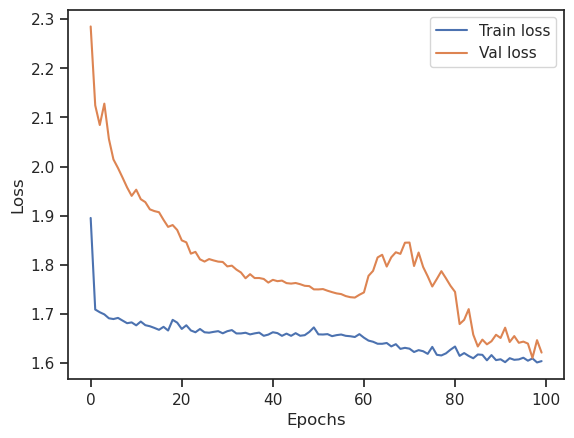

In [ ]:
sns.lineplot(x=np.arange(num_epochs), y=train_epoch_loss, label="Train loss")
sns.lineplot(x=np.arange(num_epochs), y=val_epoch_loss, label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Get all the predictions on the train and validation set

In [ ]:
train_data_loader_copy = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(Y_train)), batch_size=batch_size, num_workers=num_workers, shuffle=False)
train_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(train_data_loader_copy), total=len(train_data_loader_copy), desc="Predicting on Train set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    train_total_predictions.extend(preds)
train_total_predictions = np.argmax(np.asarray(train_total_predictions), axis=1)
ground_truth = np.argmax(Y_train, axis=1)
print("\nTrain Accuracy:", accuracy_score(train_total_predictions, ground_truth))
print("Train Precision:", precision_score(train_total_predictions, ground_truth, average="micro"))
print("Train Confusion Matrix:\n", confusion_matrix(train_total_predictions, ground_truth), "\n\n")

val_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(val_data_loader), total=len(val_data_loader), desc="Predicting on Val set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    val_total_predictions.extend(preds)
val_total_predictions = np.argmax(np.asarray(val_total_predictions), axis=1)
ground_truth = np.argmax(Y_val, axis=1)
print("\nValidation Accuracy:", accuracy_score(val_total_predictions, ground_truth))
print("Validation Precision:", precision_score(val_total_predictions, ground_truth, average="micro"))
print("Validation Confusion Matrix:\n", confusion_matrix(val_total_predictions, ground_truth), "\n\n")

test_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(test_data_loader), total=len(test_data_loader), desc="Predicting on Test set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    test_total_predictions.extend(preds)
test_total_predictions = np.argmax(np.asarray(test_total_predictions), axis=1)
ground_truth = np.argmax(Y_test, axis=1)
print("\nTest Accuracy:", accuracy_score(test_total_predictions, ground_truth))
print("Test Precision:", precision_score(test_total_predictions, ground_truth, average="micro"))
print("Test Confusion Matrix:\n", confusion_matrix(test_total_predictions, ground_truth), "\n\n")


Predicting on Train set: 100%|██████████| 35/35 [00:00<00:00, 122.00it/s]


Train Accuracy: 0.30589314377436366
Train Precision: 0.30589314377436366
Train Confusion Matrix:
 [[552 263  50 196 142 193]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [377 737  19 782 575 475]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]] 





Predicting on Val set: 100%|██████████| 9/9 [00:00<00:00, 49.54it/s]


Validation Accuracy: 0.3171402383134739
Validation Precision: 0.3171402383134739
Validation Confusion Matrix:
 [[156  81  13  55  38  60]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 77 169   4 190 141 107]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]] 





Predicting on Test set: 100%|██████████| 4/4 [00:00<00:00, 32.38it/s]


Test Accuracy: 0.34
Test Precision: 0.34
Test Confusion Matrix:
 [[130  39   9  25  50  40]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  8  55   0  40  63  41]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]] 


